In [1]:
# %matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec
from matplotlib.gridspec import GridSpec,GridSpecFromSubplotSpec
from matplotlib import animation, rc
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import axes3d

from astropy.table import Table
import astropy.units as u
import astropy.constants as const

from tqdm.notebook import trange, tqdm
import re
import warnings

In [2]:
# data = Table.read("/Users/benjaminroulston/Dropbox/Research/TDSS/Variable_Stars/HARD_COPY_ORGINAL_DATA/PROGRAM_SAMPLE/2021-07-27/FINAL_FILES/TDSS_SES+PREV_DR16DR12griLT20_GaiaEDR3_Drake2014PerVar_CSSID_ZTFIDs_LCpointer_PyHammer_EqW_LCProps.fits")
data = Table.read('/Users/benjaminroulston/Dropbox/Research/TDSS/Variable_Stars/WORKING_DIRECTORY/Statistical_Testing/LC_stat_calculations/Control_StatsCalc/TDSS_VarStar_FINAL_Var_ALL_PROP_STATS_03-15-2022.fits')

def SplitSingleSpecType(spectype):
    spectype_letters = np.array(['O', 'B', 'A', 'F', 'G', 'K', 'M', 'L', 'dC', 'DA'])
    if 'DA' in spectype:
        maintype = 9.0
        subtype = np.float64(re.split('(\d.*)', spectype)[1]) / 10.0
    elif 'dC' in spectype:
        maintype = 8.0
        subtype = np.where(np.array(['G', 'K', 'M']) == spectype[-1])[0][0] / 10.0
    else:
        maintype = np.where(spectype_letters == spectype[0])[0][0]
        subtype = np.float64(spectype[1]) / 10.0
    
    return maintype + subtype


def SplitSpecType(spectype):
    spectype_letters = np.array(['O', 'B', 'A', 'F', 'G', 'K', 'M', 'L', 'dC', 'DA'])
    if '+' in spectype:
        spectype1, spectype2 = spectype.replace("+", " ").split()
        return SplitSingleSpecType(spectype1), SplitSingleSpecType(spectype2)
    else:
        return SplitSingleSpecType(spectype), 99.0

# re.split('(\d.*)', data['PyHammerSpecType'][136])
print(data['PyHammerSpecType'][427], SplitSpecType(data['PyHammerSpecType'][427]))
print(data['PyHammerSpecType'][136], SplitSpecType(data['PyHammerSpecType'][136]))

# for spectype in data['PyHammerSpecType']:
#     print(SplitSpecType(spectype))


# for ii, spectype in enumerate(data['PyHammerSpecType']):
#     if "+" not in spectype and "dC" in spectype:
#         print(ii)
        
# print(data['PyHammerSpecType'][427])

# data['PyHammerSpecType']

all_spectype1 = np.zeros(len(data)) * np.nan
all_spectype2 = np.zeros(len(data)) * np.nan

for ii, spectype in enumerate(data['PyHammerSpecType']):
    #print(ii, spectype, SplitSpecType(spectype))
    all_spectype1[ii], all_spectype2[ii] = SplitSpecType(spectype)

print(all_spectype1)
print(all_spectype2)

pyhammer_spectype_index = data.index_column('PyHammerSpecType')

data.add_column(all_spectype1, index=pyhammer_spectype_index+1, name='PyHammerSpecType1')
data.add_column(all_spectype2, index=pyhammer_spectype_index+2, name='PyHammerSpecType2')


M_G = data['phot_g_mean_mag'] + 5 - 5*np.log10(data['rpgeo'])
MG_index = data.index_column('B_rpgeo_GaiaEDR3a')
data.add_column(M_G, index=MG_index+1, name='M_G')


pos_steps = np.arange(3.0, 10.25, 0.25)
pos_step_colnames_g = [f'ZTF_g_sigma{ss}' for ss in pos_steps]
pos_step_colnames_r = [f'ZTF_r_sigma{ss}' for ss in pos_steps]

neg_step_colnames_g = [f'ZTF_g_sigma{-ss}' for ss in pos_steps]
neg_step_colnames_r = [f'ZTF_r_sigma{-ss}' for ss in pos_steps]

sum_g_Nabove3sigma = data[pos_step_colnames_g].to_pandas().sum(axis=1).to_numpy()
sum_r_Nabove3sigma = data[pos_step_colnames_r].to_pandas().sum(axis=1).to_numpy()

sum_g_Nbelow3sigma = data[neg_step_colnames_g].to_pandas().sum(axis=1).to_numpy()
sum_r_Nbelow3sigma = data[neg_step_colnames_r].to_pandas().sum(axis=1).to_numpy()

data_panda = data.to_pandas()

mean_g_Nabove3sigma = np.zeros(len(data)) * np.nan
mean_r_Nabove3sigma = np.zeros(len(data)) * np.nan
mean_g_Nbelow3sigma = np.zeros(len(data)) * np.nan
mean_r_Nbelow3sigma = np.zeros(len(data)) * np.nan
total_mean_g = np.zeros(len(data)) * np.nan
total_mean_r = np.zeros(len(data)) * np.nan

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for ii in trange(len(data)):
        method_count1 = (np.diff(np.append(data_panda[pos_step_colnames_g].to_numpy()[ii, :], 0))*-1)
        mean_g_Nabove3sigma[ii] = np.nansum(method_count1 * pos_steps) / np.nansum(method_count1)

        method_count2 = (np.diff(np.append(data_panda[pos_step_colnames_r].to_numpy()[ii, :], 0))*-1)
        mean_r_Nabove3sigma[ii] = np.nansum(method_count2 * pos_steps) / np.nansum(method_count2)

        method_count3 = (np.diff(np.append(data_panda[neg_step_colnames_g].to_numpy()[ii, :], 0))*-1)
        mean_g_Nbelow3sigma[ii] = np.nansum(method_count3 * -pos_steps) / np.nansum(method_count3)

        method_count4 = (np.diff(np.append(data_panda[neg_step_colnames_r].to_numpy()[ii, :], 0))*-1)
        mean_r_Nbelow3sigma[ii] = np.nansum(method_count4 * -pos_steps) / np.nansum(method_count4)
        
        total_mean_g[ii] = (np.nansum(method_count1 * pos_steps) + np.nansum(method_count3 * -pos_steps)) / (np.nansum(method_count1) + np.nansum(method_count3))
        total_mean_r[ii] = (np.nansum(method_count2 * pos_steps) + np.nansum(method_count4 * -pos_steps)) / (np.nansum(method_count2) + np.nansum(method_count4))
    


data.add_column(sum_g_Nabove3sigma, name='ZTF_g_Nabove3sigma')
data.add_column(sum_g_Nbelow3sigma, name='ZTF_g_Nbelow3sigma')
data.add_column(total_mean_g, name='ZTF_g_N3sigma')

data.add_column(sum_r_Nabove3sigma, name='ZTF_r_Nabove3sigma')
data.add_column(sum_r_Nbelow3sigma, name='ZTF_r_Nbelow3sigma')
data.add_column(total_mean_r, name='ZTF_r_N3sigma')


# data

M6 (6.6, 99.0)
M2 (6.2, 99.0)
[3.4 4.4 5.4 ... 6.3 6.3 6.6]
[99.  99.   9.1 ... 99.   9.7 99. ]


  0%|          | 0/21257 [00:00<?, ?it/s]

IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out


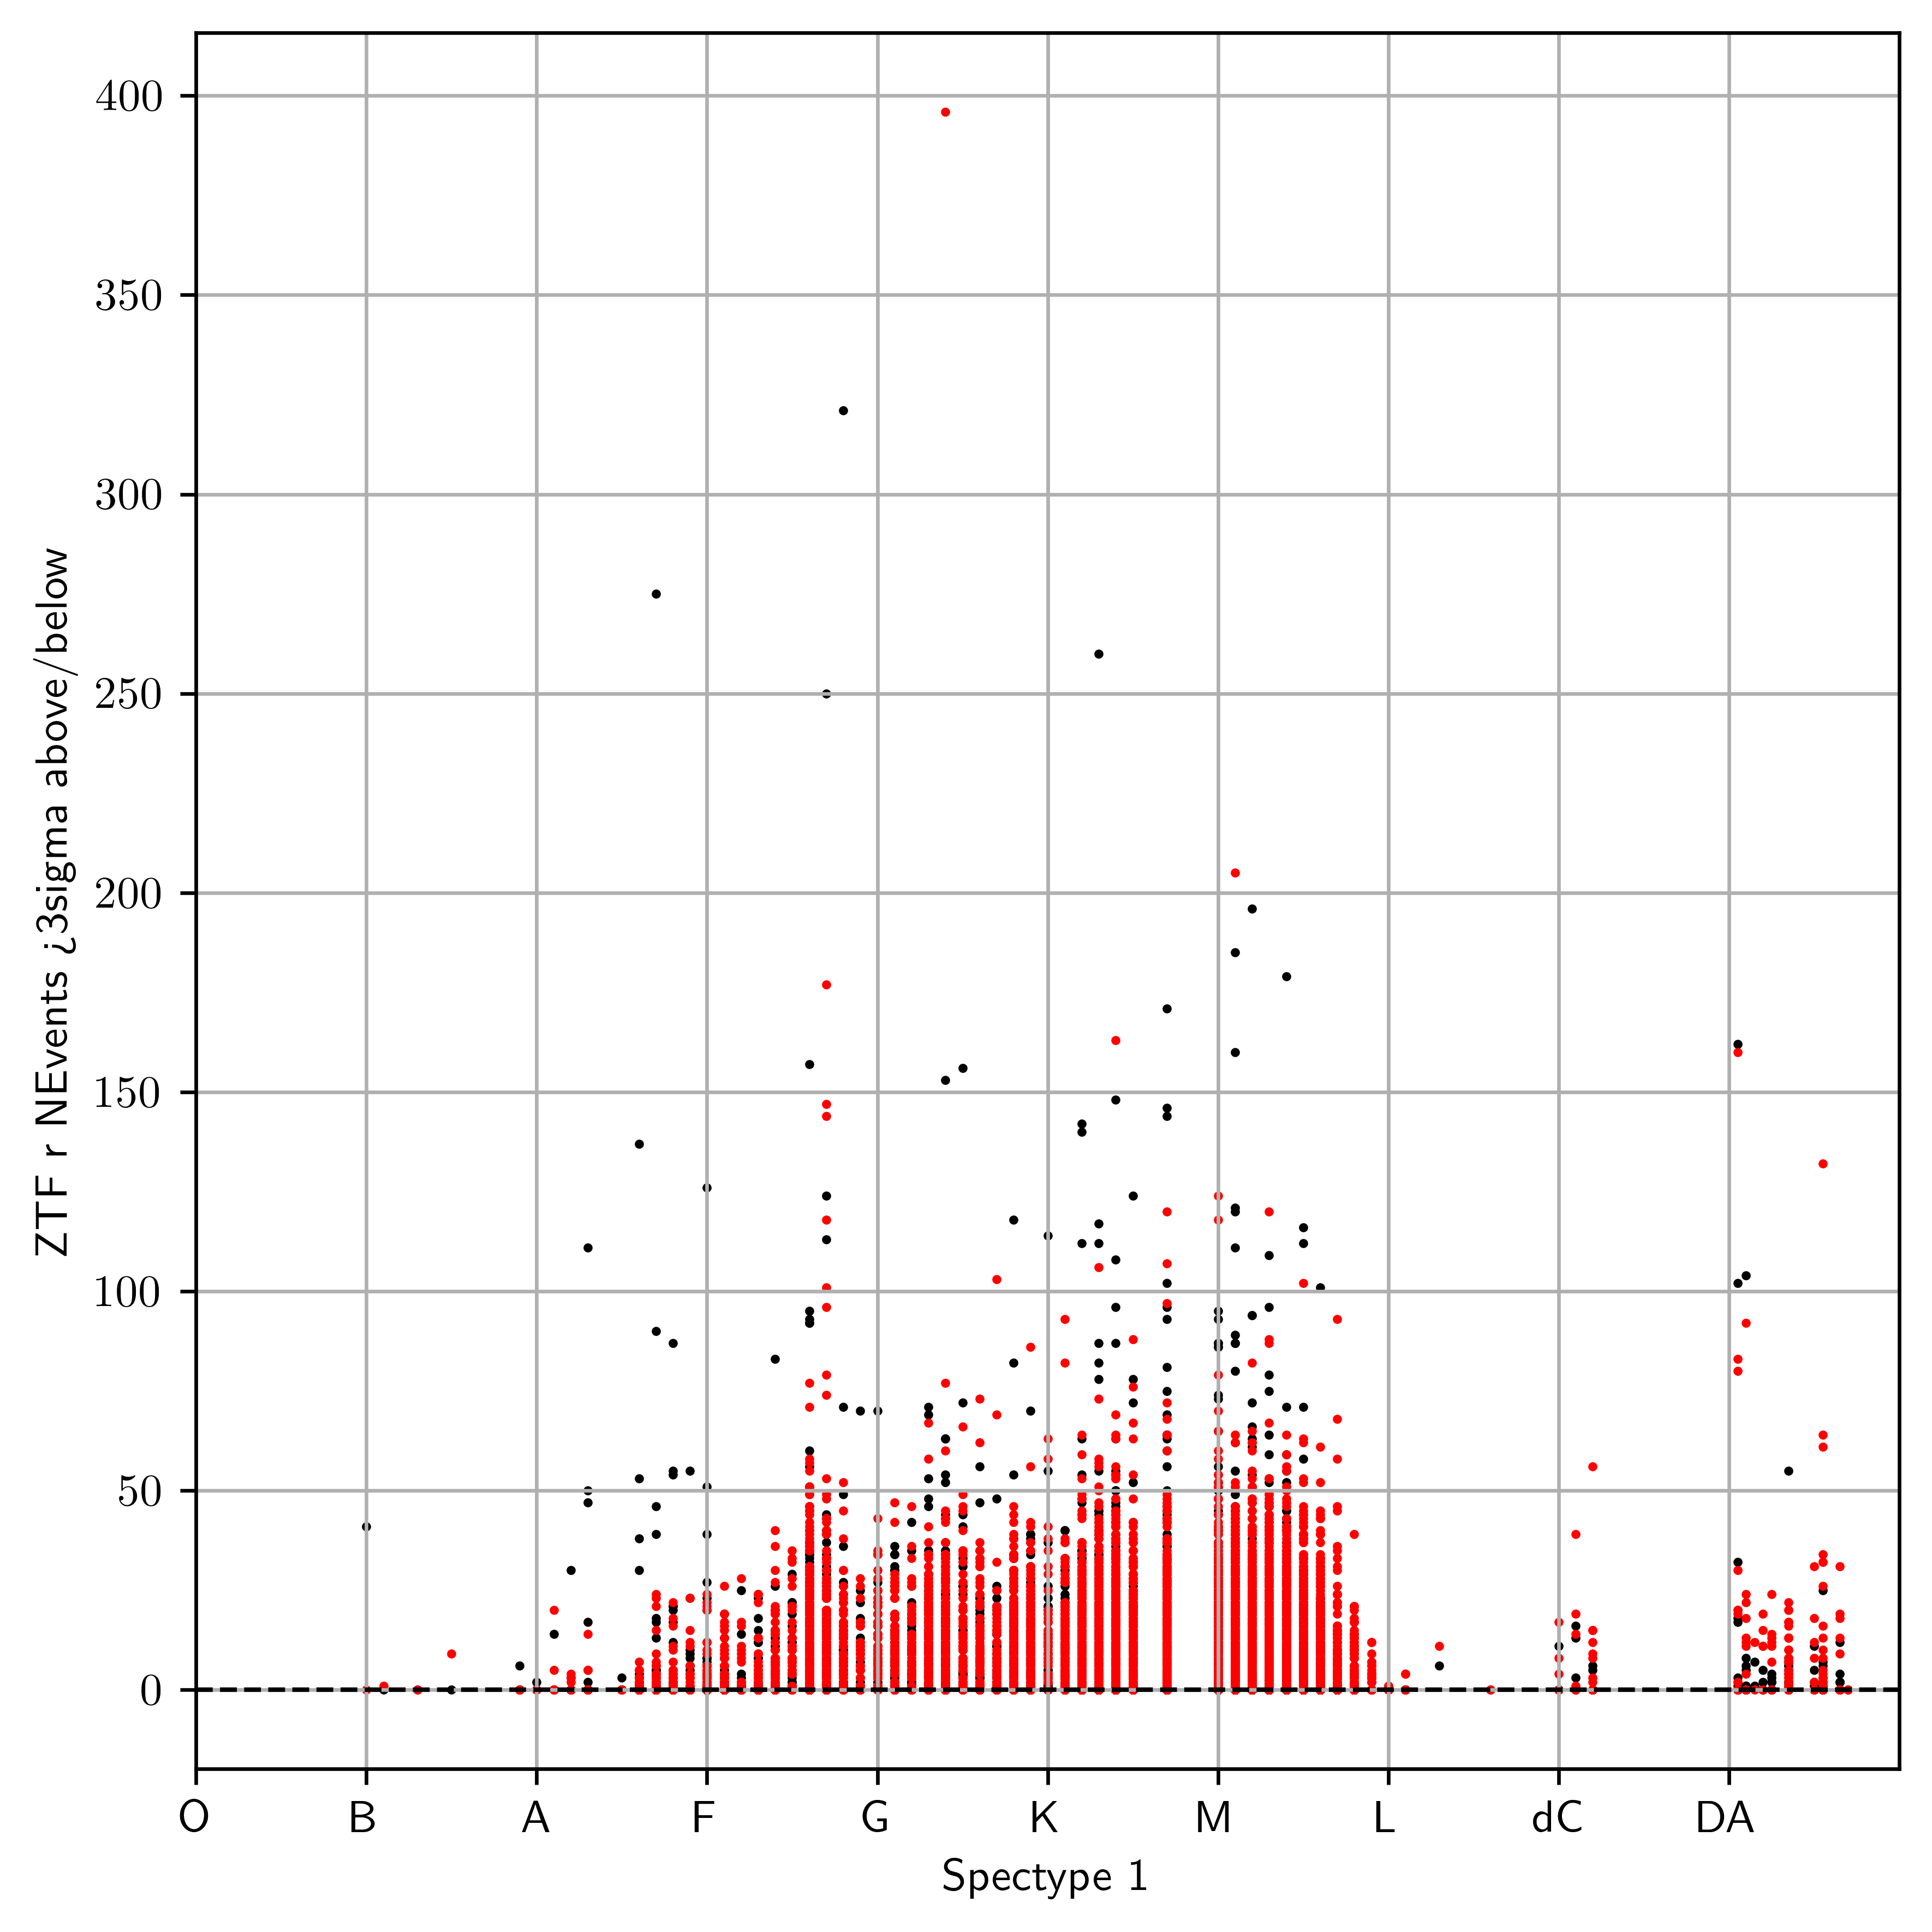

In [8]:
fig = plt.figure(figsize=(6,6), dpi=600) 
ax = plt.gca()
# ax.scatter(data['PyHammerSpecType1'], data['ZTF_r_N3sigma'], s=1, c='k')

ax.scatter(data['PyHammerSpecType1'], data['ZTF_r_Nabove3sigma'], s=1, c='k')
ax.scatter(data['PyHammerSpecType1'], data['ZTF_r_Nbelow3sigma'], s=1, c='r')


ax.set_xlabel('Spectype 1')
# ax.set_ylabel('ZTF r mean 3sigma above/below')
ax.set_ylabel('ZTF r NEvents >3sigma above/below')


ax.set_xlim(0,10)

ax.xaxis.set_major_locator(ticker.FixedLocator(np.arange(10)))
# ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.2))

# ax.yaxis.set_major_locator(ticker.MultipleLocator(2.5))
# ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.25))

spectype_letters = np.array(['O', 'B', 'A', 'F', 'G', 'K', 'M', 'L', 'dC', 'DA'])
ax.set_xticklabels(spectype_letters)

ax.axhline(0.0, c='k', lw=1.0, ls='dashed')
ax.grid()

plt.tight_layout()
plt.savefig("VarStar_r_meanALL3sigma.pdf", dpi=600, bbox_inches='tight', facecolor='white')
plt.savefig("VarStar_r_meanALL3sigma.png", dpi=600, bbox_inches='tight', facecolor='white')

In [21]:
OPTICS?

Init signature:
OPTICS(
    *,
    min_samples=5,
    max_eps=inf,
    metric='minkowski',
    p=2,
    metric_params=None,
    cluster_method='xi',
    eps=None,
    xi=0.05,
    predecessor_correction=True,
    min_cluster_size=None,
    algorithm='auto',
    leaf_size=30,
    memory=None,
    n_jobs=None,
)
Docstring:     
Estimate clustering structure from vector array.

OPTICS (Ordering Points To Identify the Clustering Structure), closely
related to DBSCAN, finds core sample of high density and expands clusters
from them [1]_. Unlike DBSCAN, keeps cluster hierarchy for a variable
neighborhood radius. Better suited for usage on large datasets than the
current sklearn implementation of DBSCAN.

Clusters are then extracted using a DBSCAN-like method
(cluster_method = 'dbscan') or an automatic
technique proposed in [1]_ (cluster_method = 'xi').

This implementation deviates from the original OPTICS by first performing
k-nearest-neighborhood searches on all points to identify core siz

In [32]:
selection_index = (data['ZTF_r_logProb'] <= -15.0).data & (data['ZTF_r_P'] <= 10.0).data
# selection_index = (data['ZTF_r_P'] <= 10.0).data


# selected_data = data[selection_index][['bp_rp', 'ZTF_r_P', 'ZTF_r_a95', 'ZTF_r_lc_skew', 'ZTF_r_Mt', 'ZTF_r_Amp', 'ZTF_r_VarStat']]
# selected_data = data[selection_index][['bp_rp', 'M_G', 'ZTF_r_P', 'ZTF_r_a95', 'ZTF_r_lc_skew', 'ZTF_r_Mt', 'ZTF_r_Amp', 'PyHammerSpecType1', 'PyHammerSpecType2']]
selected_data = data[selection_index][['bp_rp', 'ZTF_r_P', 'ZTF_r_lc_skew', 'ZTF_r_Mt', 'ZTF_r_Amp', 'PyHammerSpecType1']]

selected_data

<Table length=2554>
 bp_rp         ZTF_r_P          ZTF_r_lc_skew           ZTF_r_Mt           ZTF_r_Amp      PyHammerSpecType1
  mag                                                                                                      
float64        float64             float64              float64             float64            float64     
-------- ------------------- -------------------- ------------------- ------------------- -----------------
0.513842 0.24683069389044662     -0.7790990413953 0.28639334440231323 0.47931650838365414               3.4
1.020573  0.1331430275659324    0.782755434433646  0.7289783954620361  0.3736863828538759               5.2
0.613438 0.24789045225134107  -0.8557646199006506   0.270148366689682 0.40324247733207486               3.6
0.601294  0.2740086367522304  -0.5274601729640936  0.3715853691101074  0.6078222501560369               3.1
0.825874  0.2514736355040537  -0.8268640209301621  0.2719516456127167  0.6612663387063691               3.6
0.634766  0.7929711041329652 0.058775839461369175  0.5453260540962219 0.36958364182312664               3.6
     ...                 ...                  ...                 ...                 ...               ...
0.560238 0.34347736484165686 -0.08259409968271228  0.4784765839576721 0.33901497637526745               3.4
1.252174 0.13077639329169413    0.754381865442633  0.7207354307174683 0.47532524352270755               5.4
0.662626  0.6133012781198636  -0.2358068954639633 0.46056216955184937  0.4131228794691211               3.6
0.682322  0.5953089653530181  -0.3056683330788469  0.4210757613182068    0.46066815691632               3.6
0.616163  0.5775672865888876  -0.3516070851595218   0.387557715177536  0.4800094961794734               3.6
0.664499  0.2603759829193355  -0.6686412224028838 0.29773053526878357  0.4655571774958034               3.3
0.558689  0.2575116137737812  -0.3644844728288166  0.3794386386871338  0.3209843435861437               2.8

In [33]:
def make_X_astroTable(table):
    hold = []
    for col in table.colnames:
        if hasattr(table[col].data, 'mask'):
            if col=='ZTF_r_logProb':
                col_hold = np.array(table[col].data.data.tolist())
                col_hold[np.where(~np.isfinite(col_hold))[0]] = 0.0
                hold.append(col_hold.tolist())
            else:
                hold.append(table[col].data.data.tolist())
        else:
            hold.append(table[col].data.tolist())
    return np.array(hold).T

X = make_X_astroTable(selected_data)

######################################################################
######################################################################
######################################################################
######################################################################

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
imp = IterativeImputer(max_iter=10, random_state=0)
imp.fit(X)

X = imp.transform(X)

######################################################################
######################################################################
######################################################################
######################################################################

from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X)

######################################################################
######################################################################
######################################################################
######################################################################
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
pca.fit(X_scaled)

print(pca.explained_variance_ratio_)
print(pca.singular_values_)

pca_X = pca.transform(X_scaled)

######################################################################
######################################################################
######################################################################
######################################################################

# from sklearn.cluster import AgglomerativeClustering
# clustering = AgglomerativeClustering(n_clusters=10).fit(X)
# print(np.unique(clustering.labels_, return_counts=True))

######################################################################

from sklearn.cluster import KMeans
clustering = KMeans(n_clusters=5, algorithm='full').fit(pca_X)
print(np.unique(clustering.labels_, return_counts=True))

######################################################################

# from sklearn.cluster import MeanShift
# clustering = MeanShift().fit(X_scaled)
# print(np.unique(clustering.labels_, return_counts=True))

[0.47480661 0.19803378 0.16812956]
[85.29910037 55.08783578 50.75842113]
(array([0, 1, 2, 3, 4], dtype=int32), array([ 752,  751,   40, 1006,    5]))


IndexError: index 7 is out of bounds for axis 1 with size 7

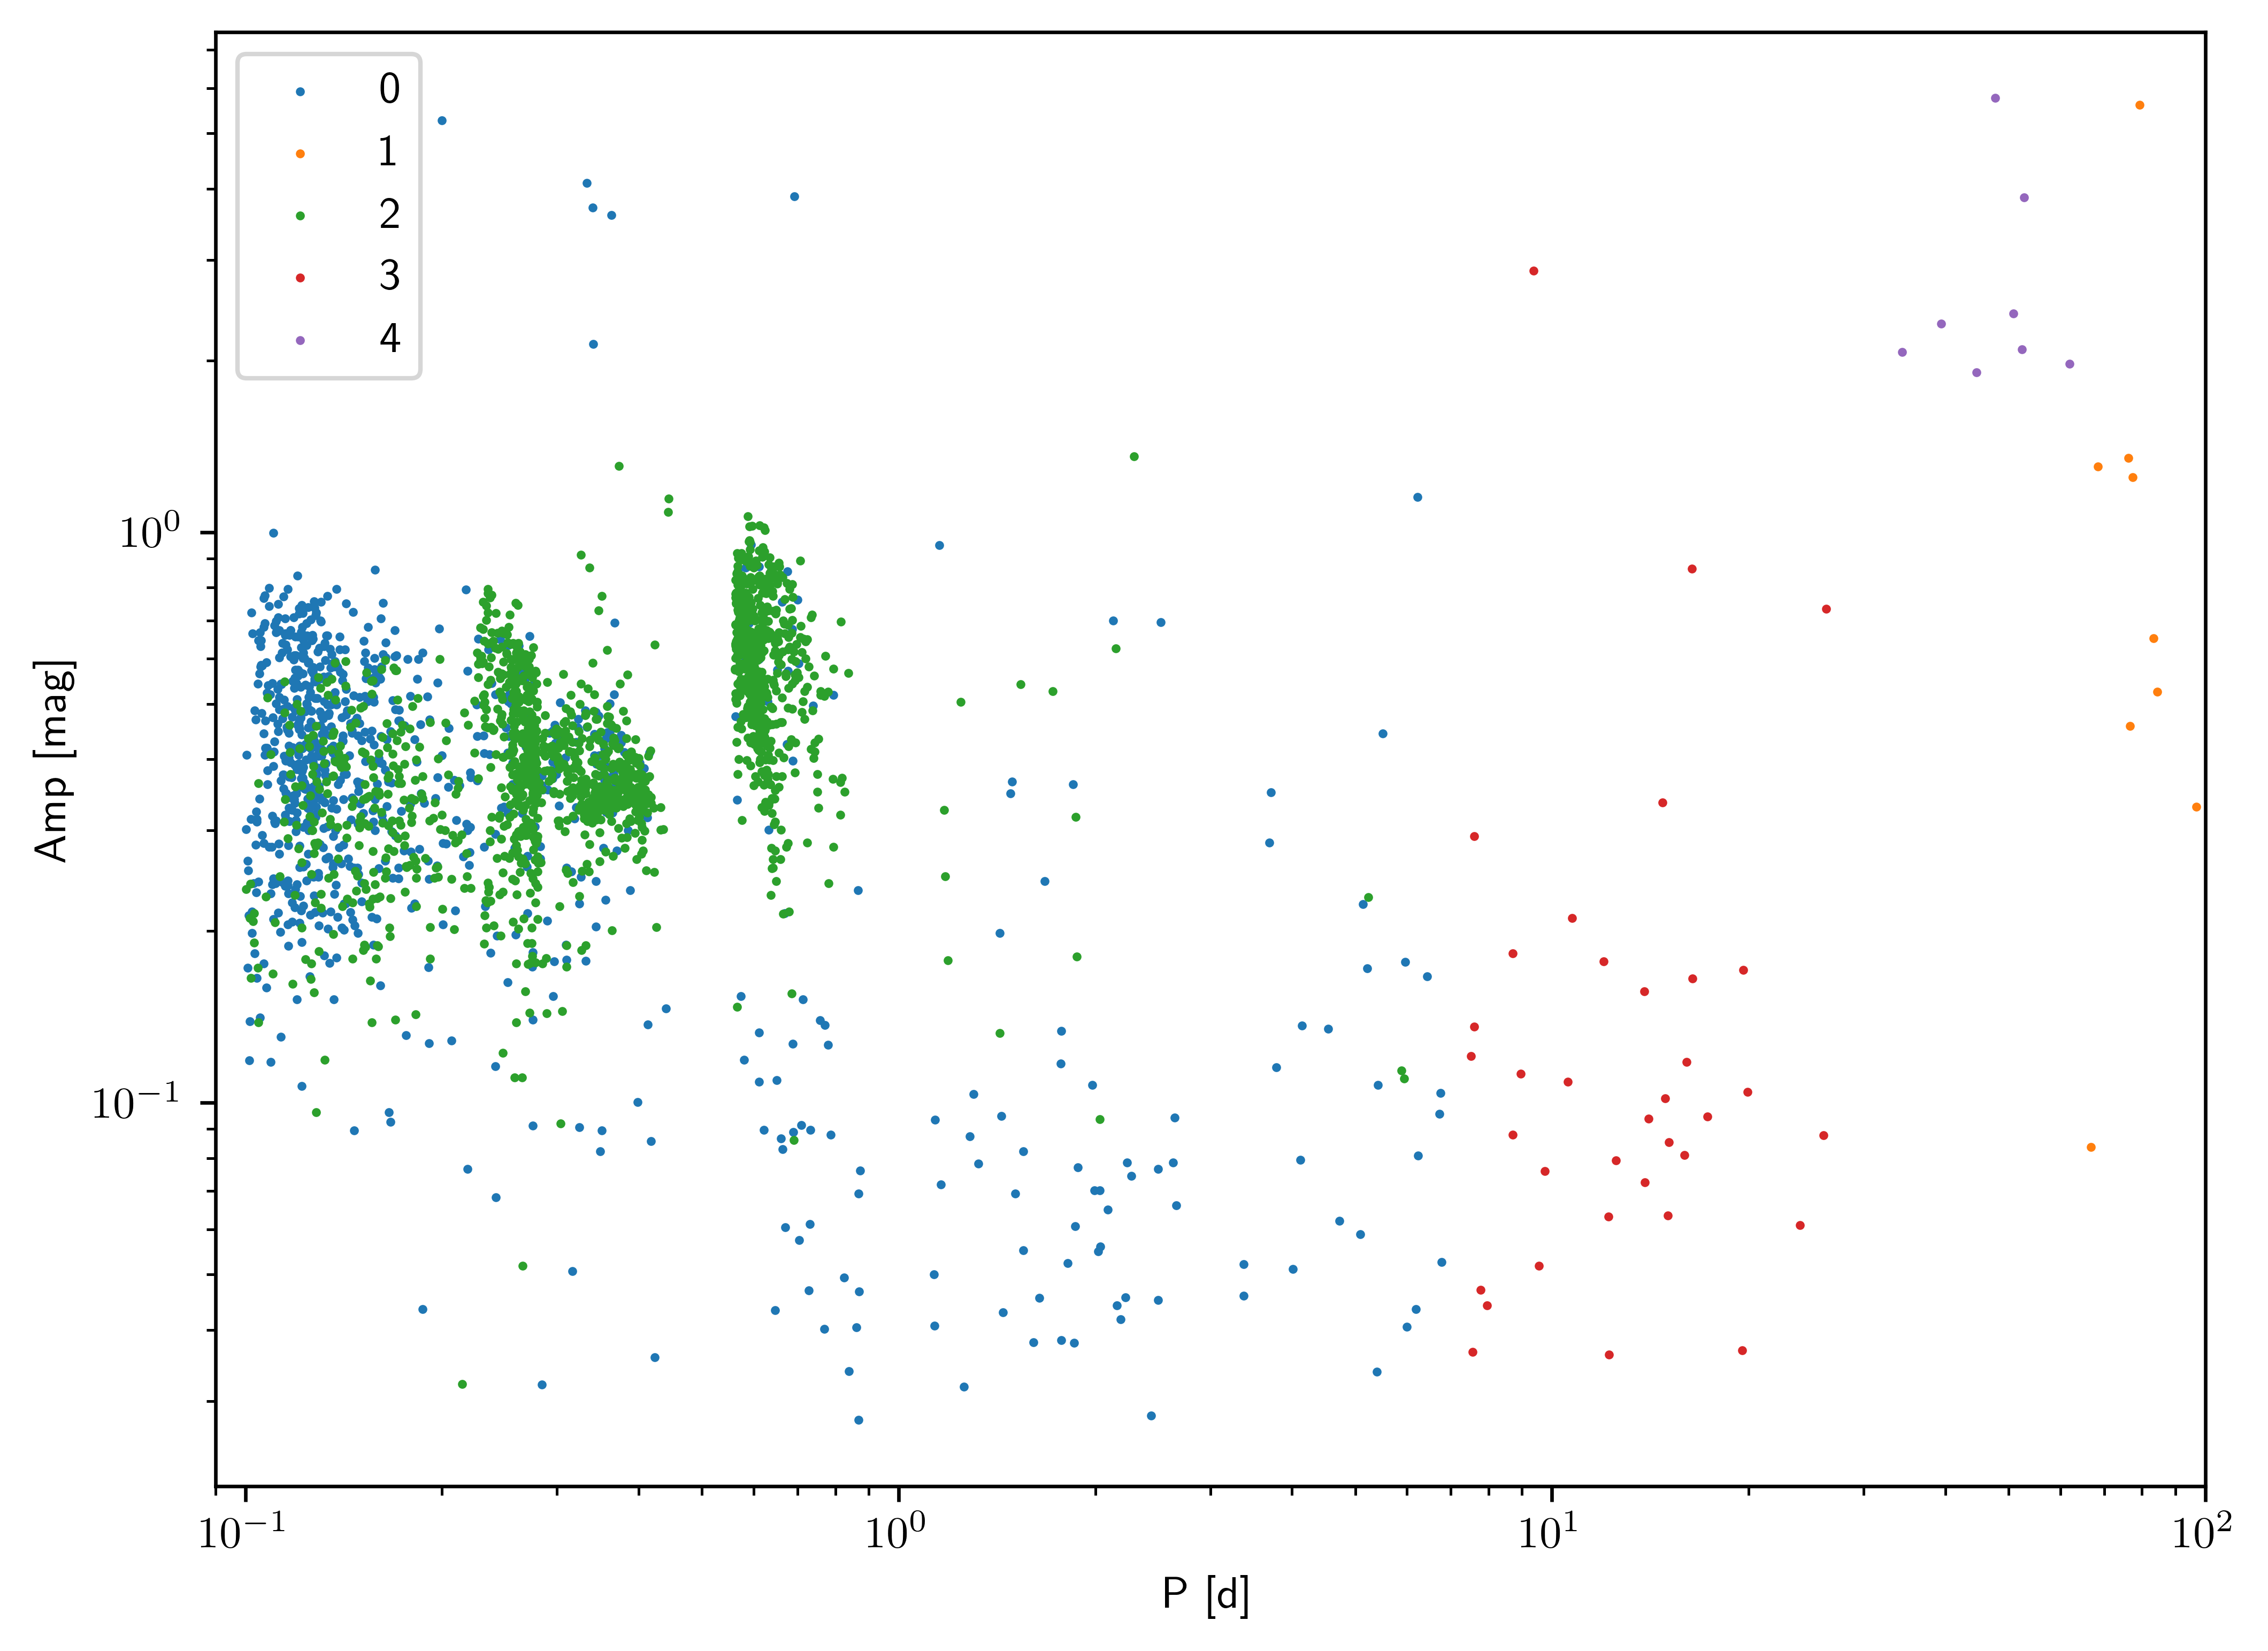

<Figure size 4800x3600 with 0 Axes>

In [31]:
# %matplotlib widget
# %matplotlib inline  
# %matplotlib notebook
######################################################################

fig = plt.figure(figsize=(8,6), dpi=600)
for ii in np.unique(clustering.labels_):
    plt.scatter(X[:,2][(clustering.labels_ == ii)], X[:, 6][(clustering.labels_ == ii)], s=1, label=ii)

plt.xlim(0.09,100)

plt.xscale('log')
plt.yscale('log')

plt.legend(loc='best')

plt.xlabel('P [d]')
plt.ylabel('Amp [mag]')

######################################################################


fig = plt.figure(figsize=(8,6), dpi=600)
for ii in np.unique(clustering.labels_):
    plt.scatter(X[:,1][(clustering.labels_ == ii)], X[:, 7][(clustering.labels_ == ii)], s=1, label=ii)

# plt.xlim(0.09,100)

# plt.xscale('log')
# plt.yscale('log')

plt.legend(loc='best')

plt.xlabel('Bp - Rp [mag]')
plt.ylabel('Spectral Type')

######################################################################


fig = plt.figure(figsize=(8,6), dpi=600)

for ii in np.unique(clustering.labels_):
    plt.scatter(X[:,0][(clustering.labels_ == ii)], X[:, 1][(clustering.labels_ == ii)], s=1, label=ii)

plt.ylim(0.0,15)

# plt.xscale('log')
# plt.yscale('log')

plt.legend(loc='best')

plt.xlabel('Bp - Rp [mag]')
plt.ylabel('M$_G$ [mag]')

ax = plt.gca()
ax.invert_yaxis()

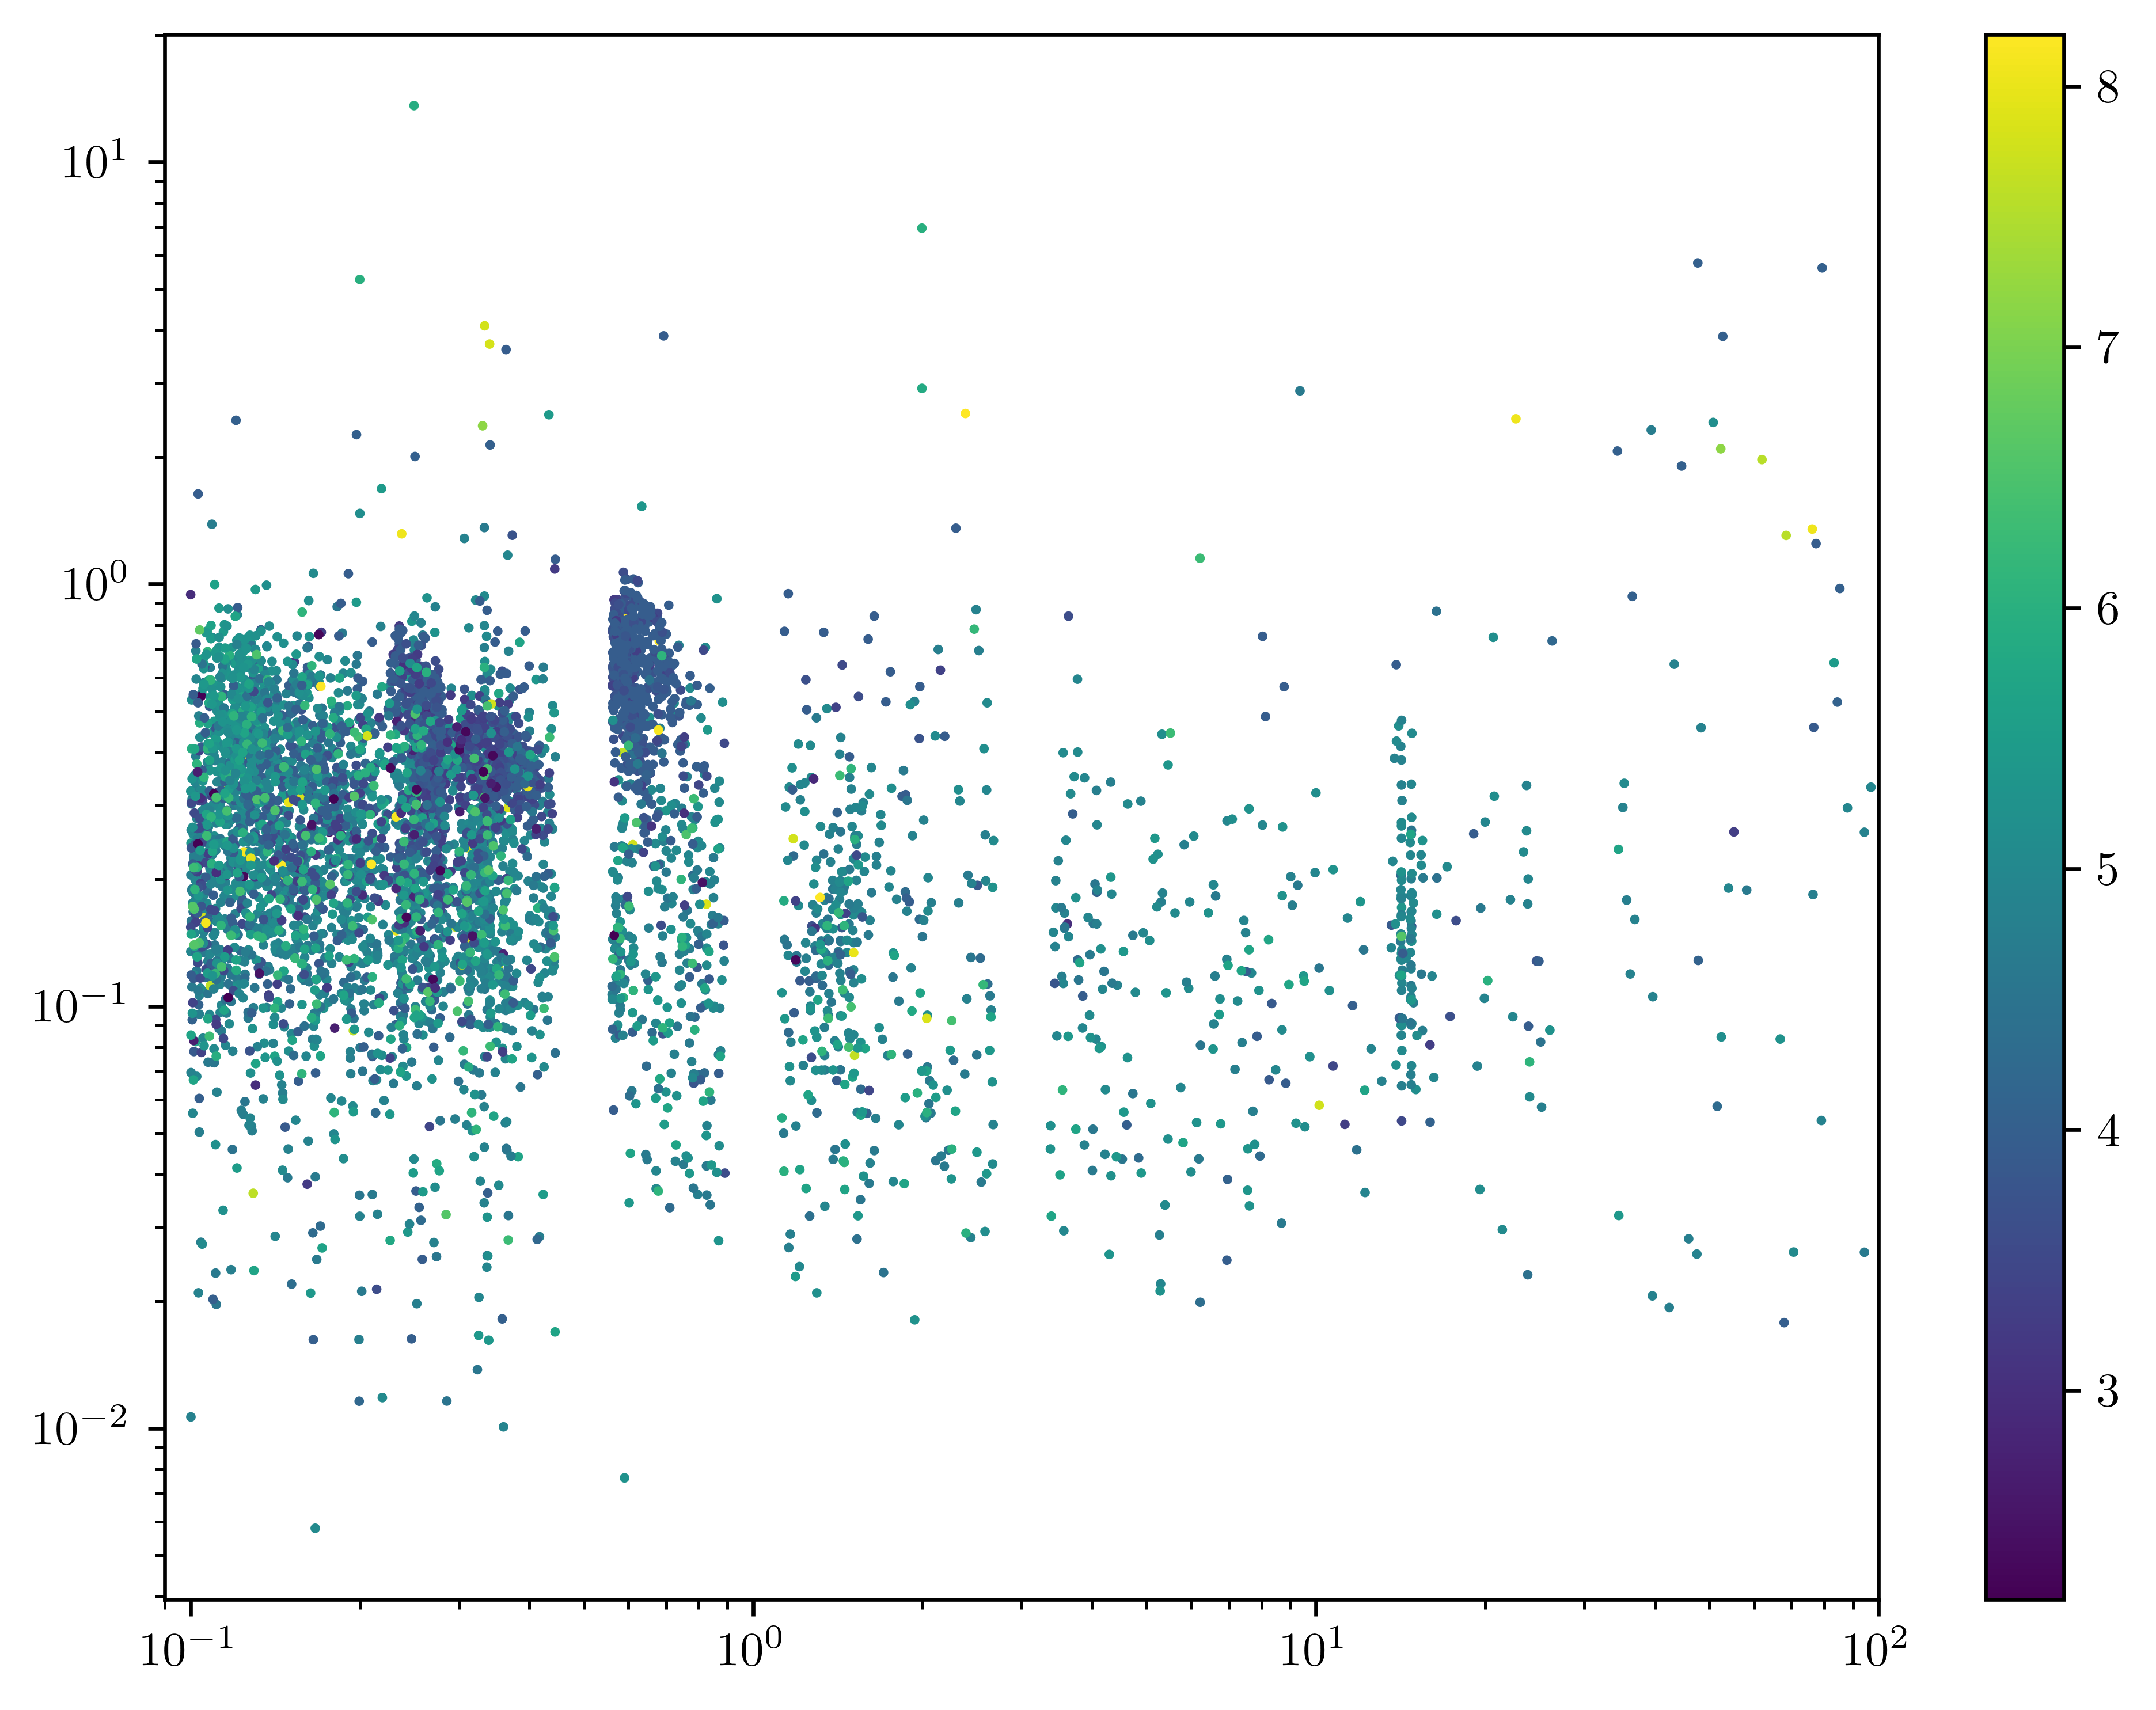

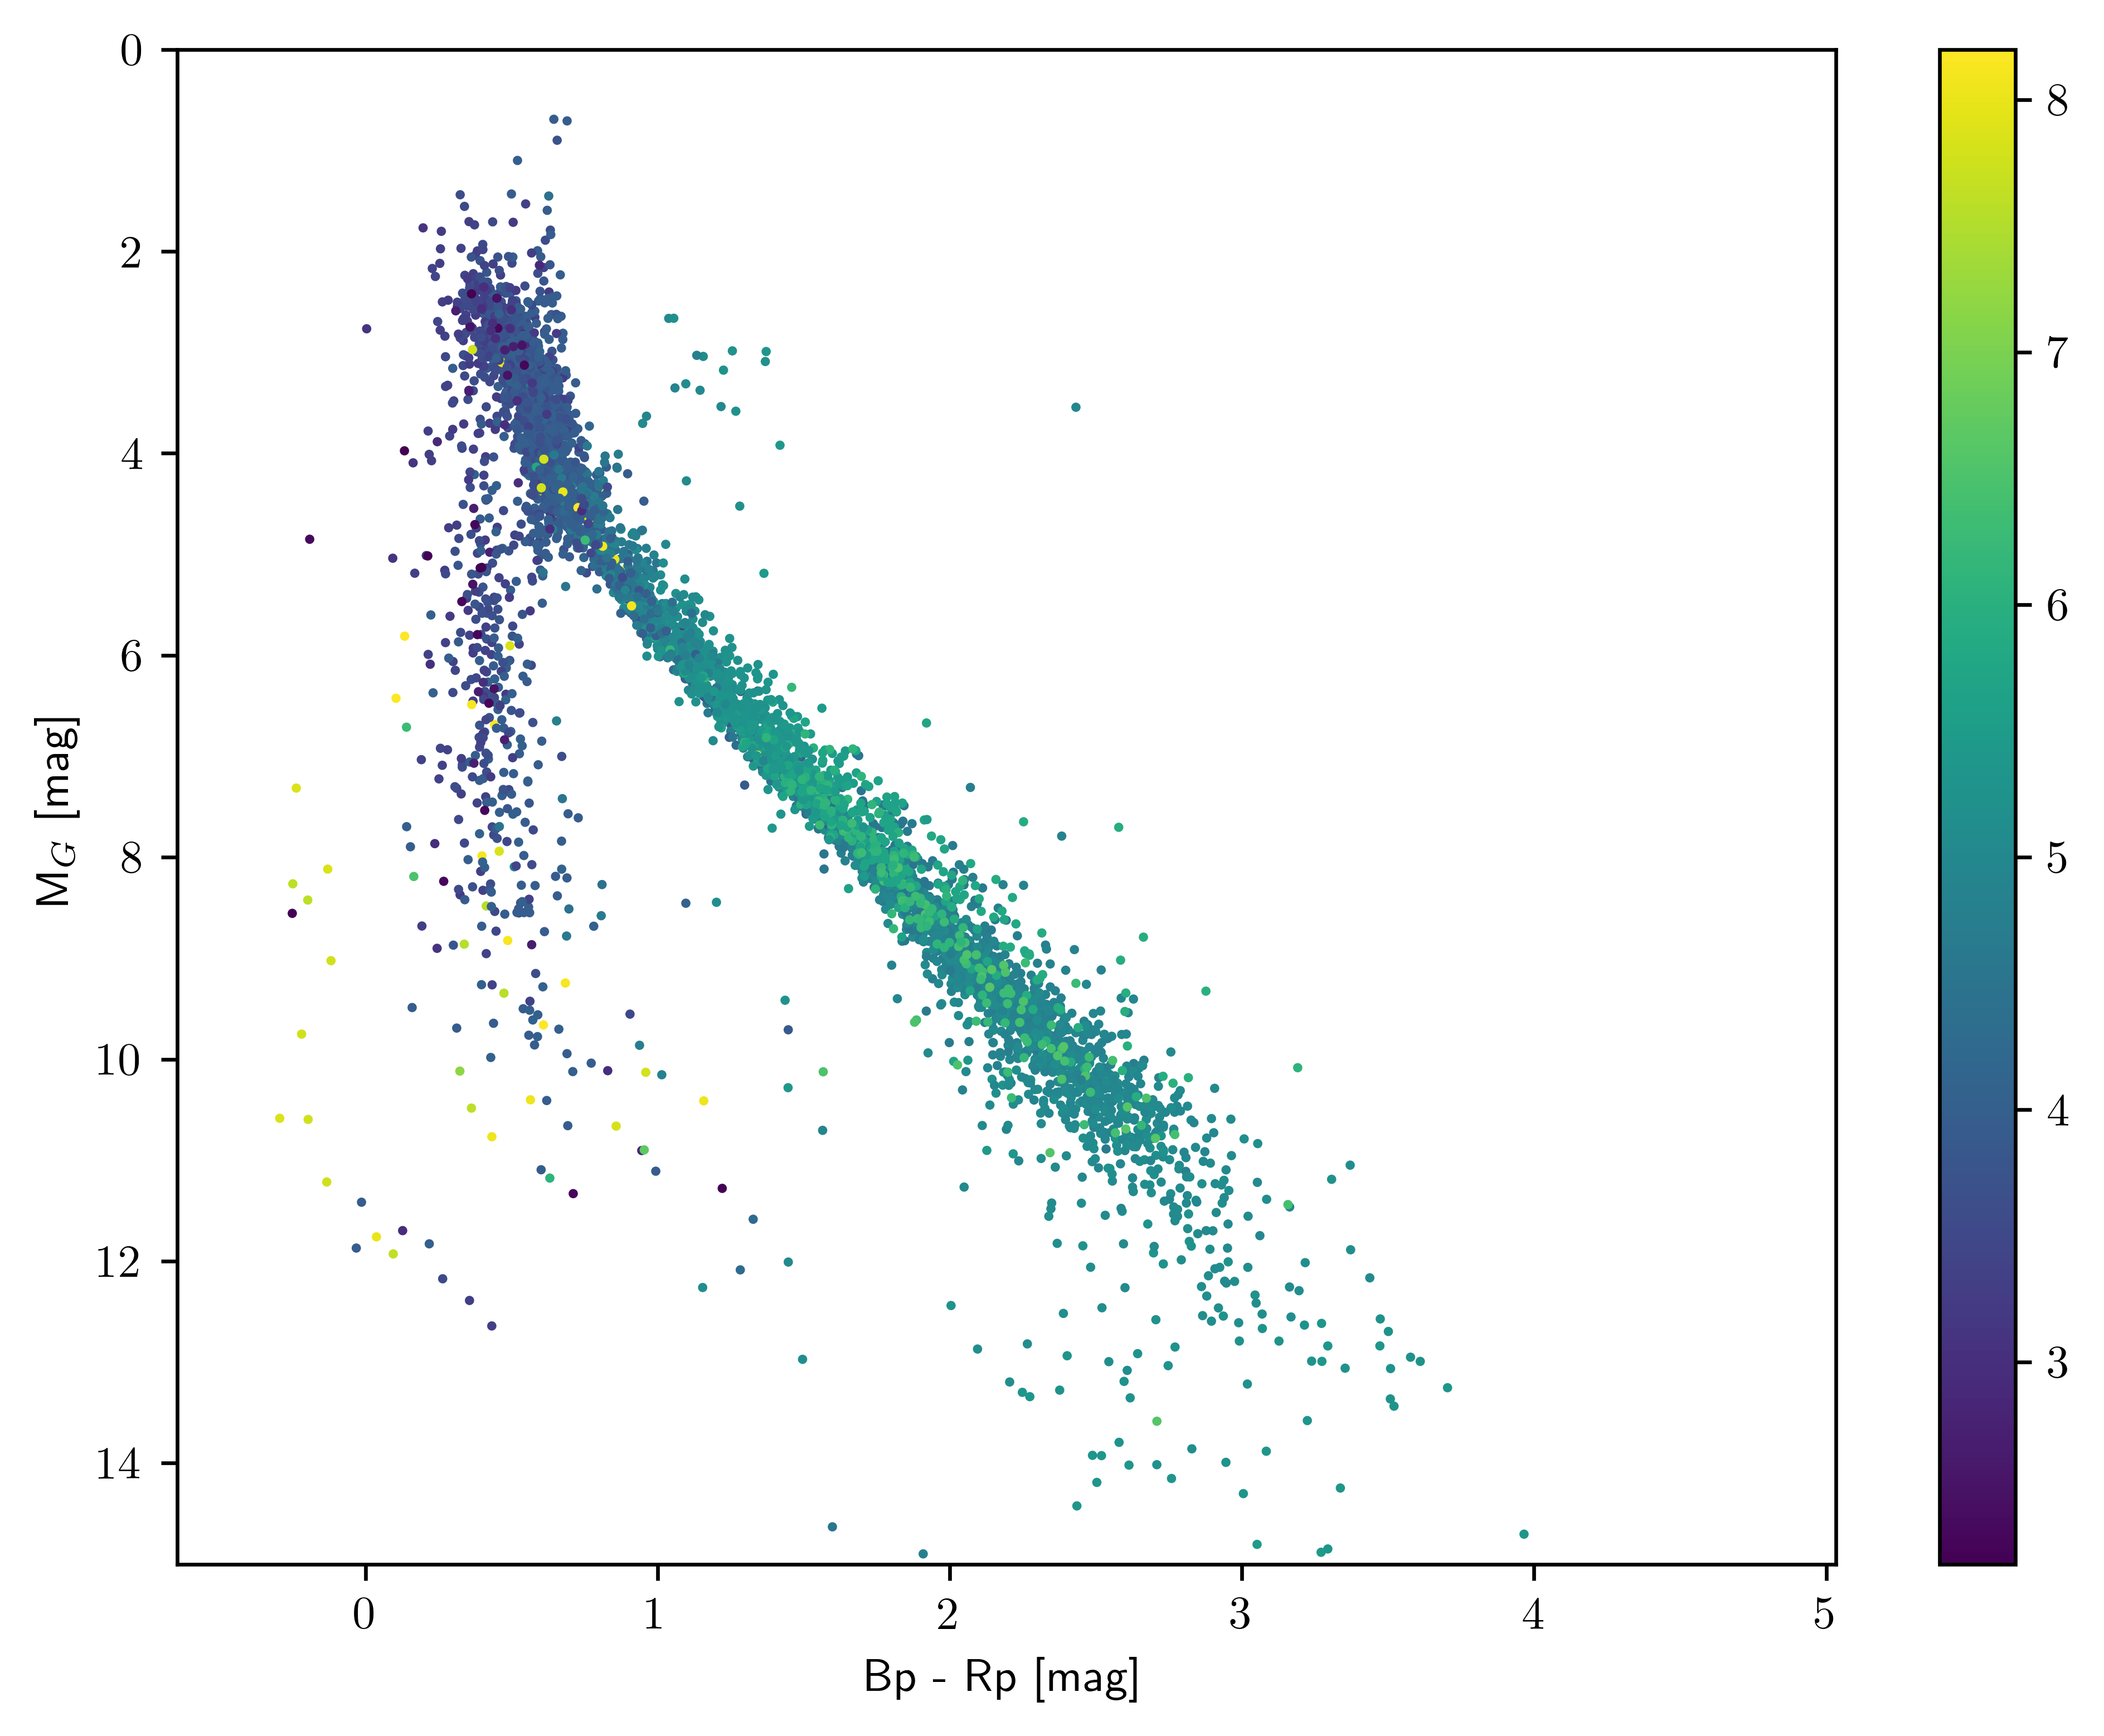

In [211]:
fig = plt.figure(figsize=(8,6), dpi=600)
for ii in np.unique(clustering.labels_):
    plt.scatter(X[:,2][(clustering.labels_ == ii)], X[:, 6][(clustering.labels_ == ii)], c=X[:, 7][(clustering.labels_ == ii)], s=1, label=ii)

plt.xlim(0.09,100)

plt.xscale('log')
plt.yscale('log')

plt.colorbar()


######################################################################


fig = plt.figure(figsize=(8,6), dpi=600)

for ii in np.unique(clustering.labels_):
    plt.scatter(X[:,0][(clustering.labels_ == ii)], X[:, 1][(clustering.labels_ == ii)], c=X[:, 7][(clustering.labels_ == ii)], s=1)

plt.ylim(0.0,15)

# plt.xscale('log')
# plt.yscale('log')

# plt.legend(loc='best')

plt.xlabel('Bp - Rp [mag]')
plt.ylabel('M$_G$ [mag]')

ax = plt.gca()
ax.invert_yaxis()

plt.colorbar()

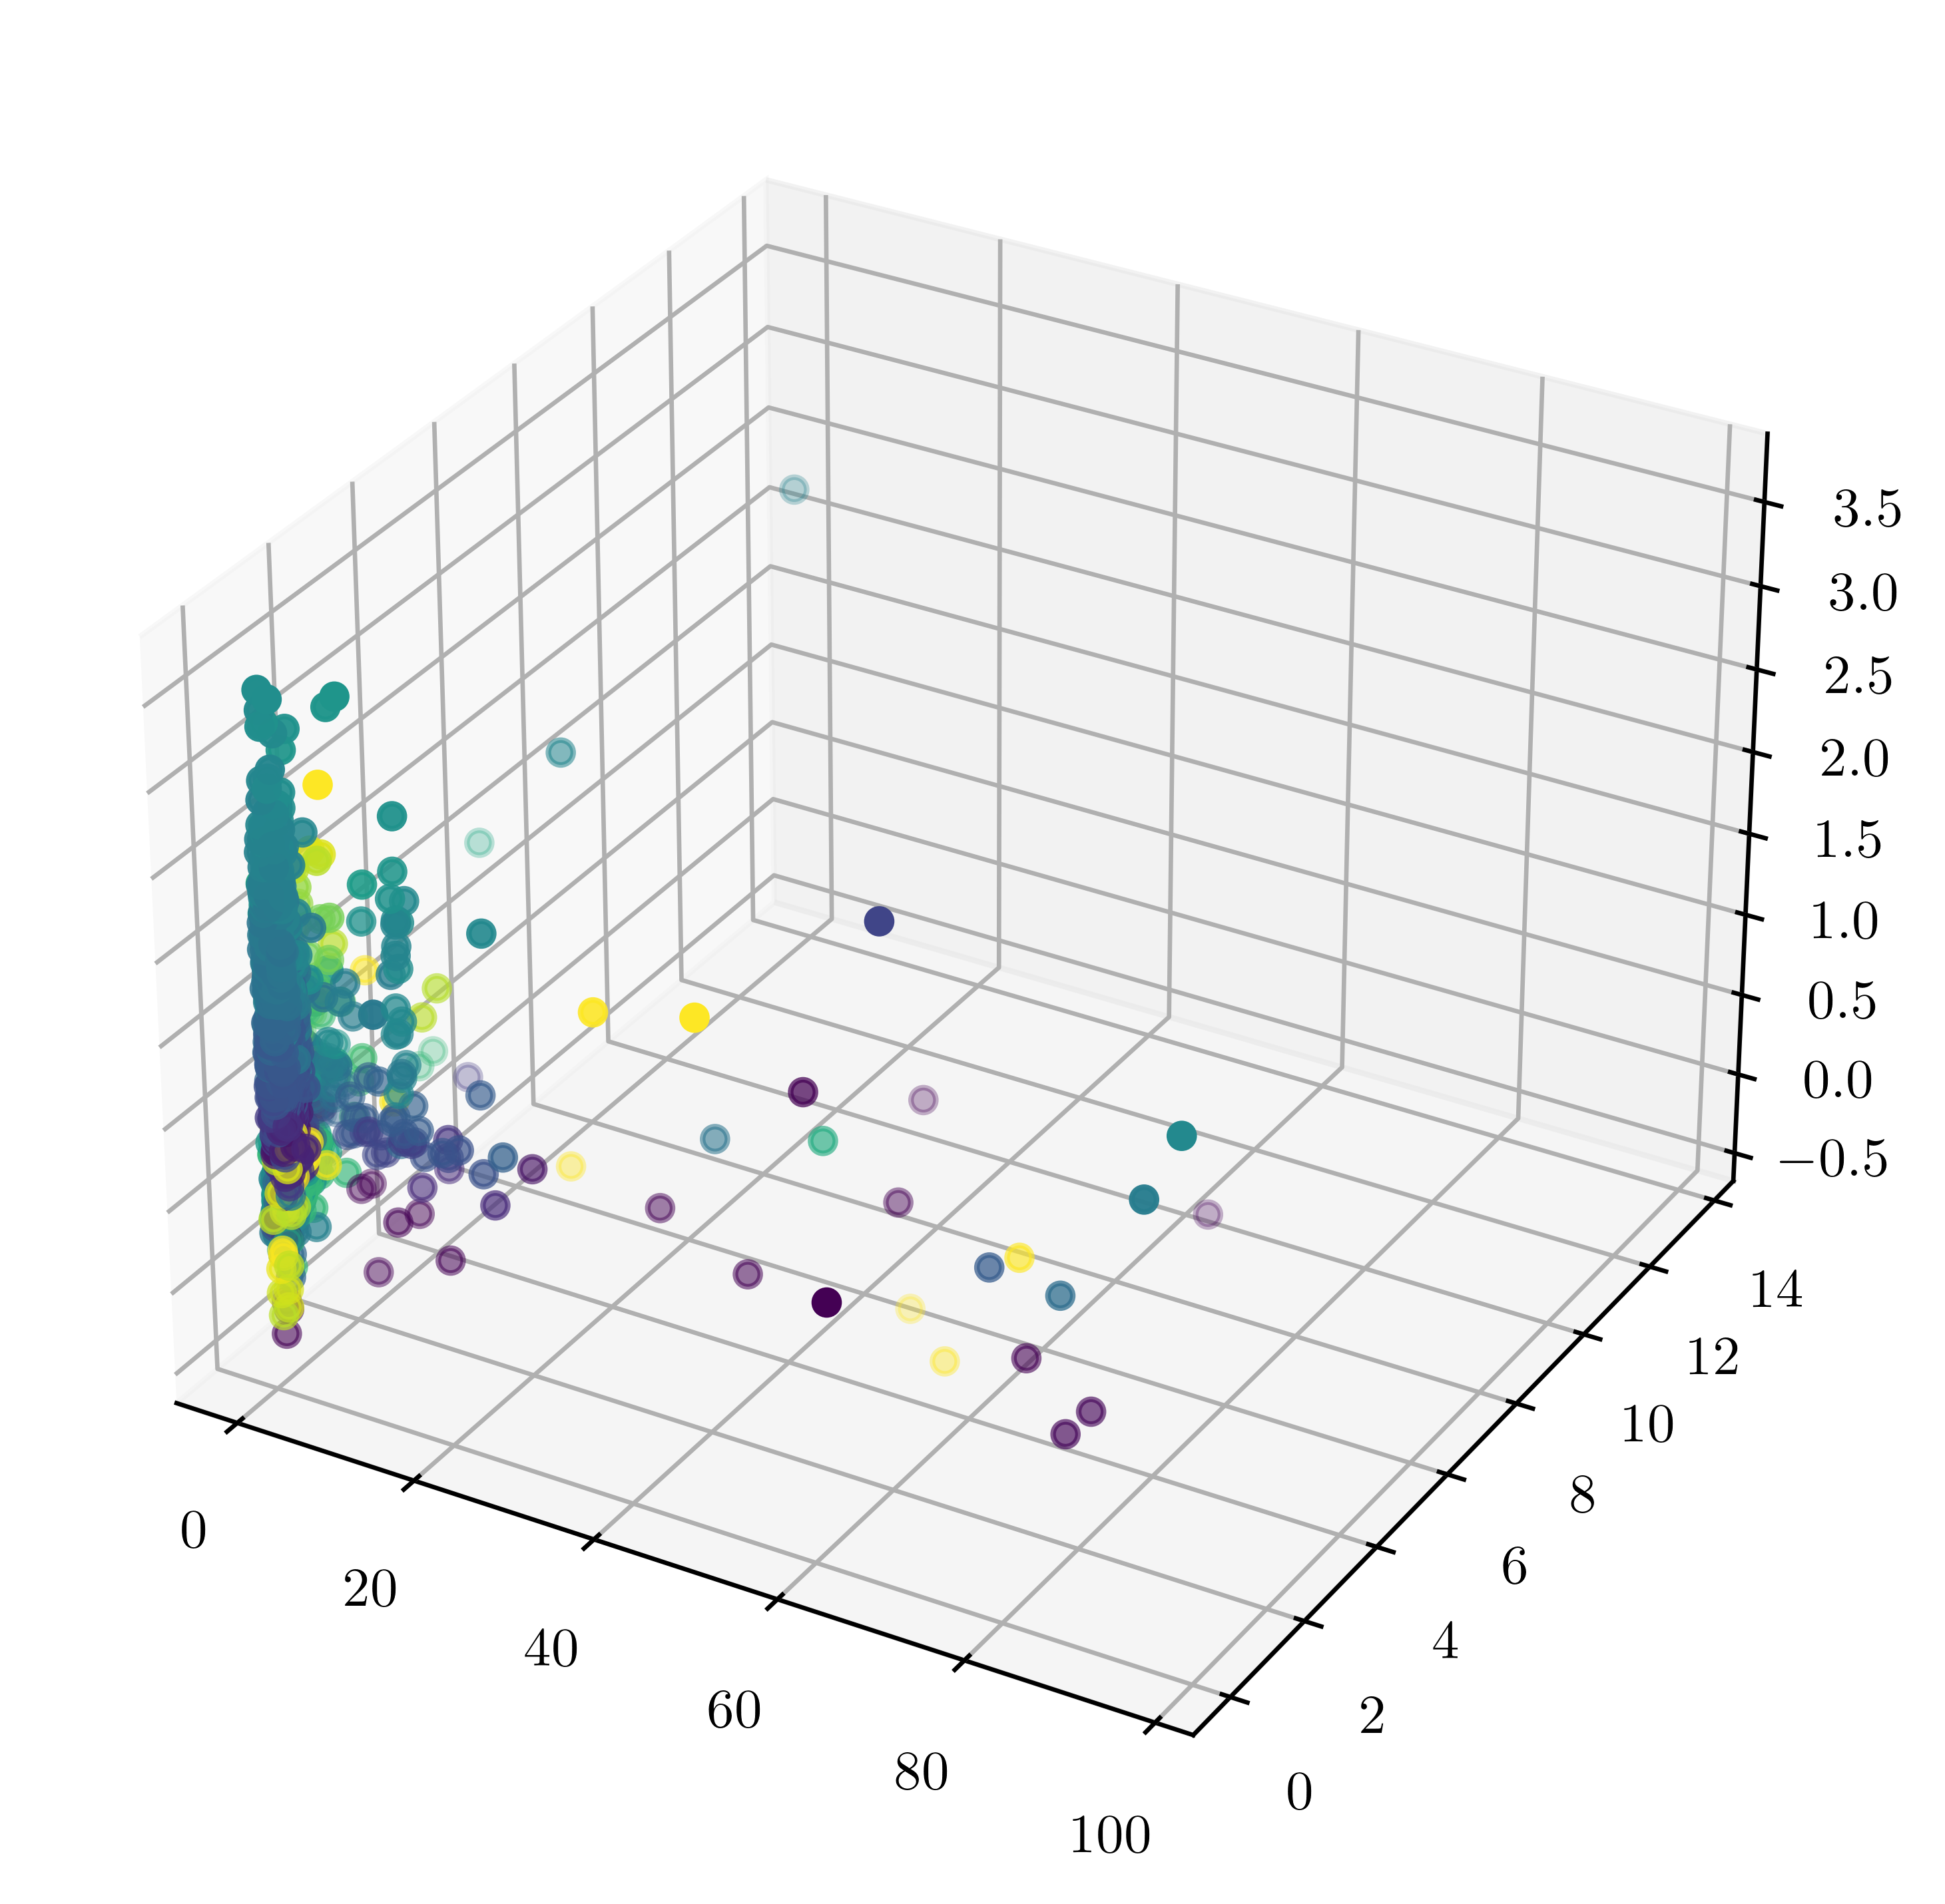

In [178]:
fig = plt.figure(figsize=(8,6), dpi=600)
ax = fig.add_subplot(projection='3d')

for ii in np.unique(clustering.labels_):
    ax.scatter(X[:,1][(clustering.labels_ == ii)],
                X[:, 5][(clustering.labels_ == ii)],
                X[:, 0][(clustering.labels_ == ii)],
                c=X[:, 6][(clustering.labels_ == ii)], label=ii)

# ax.xlim(0.01,100)



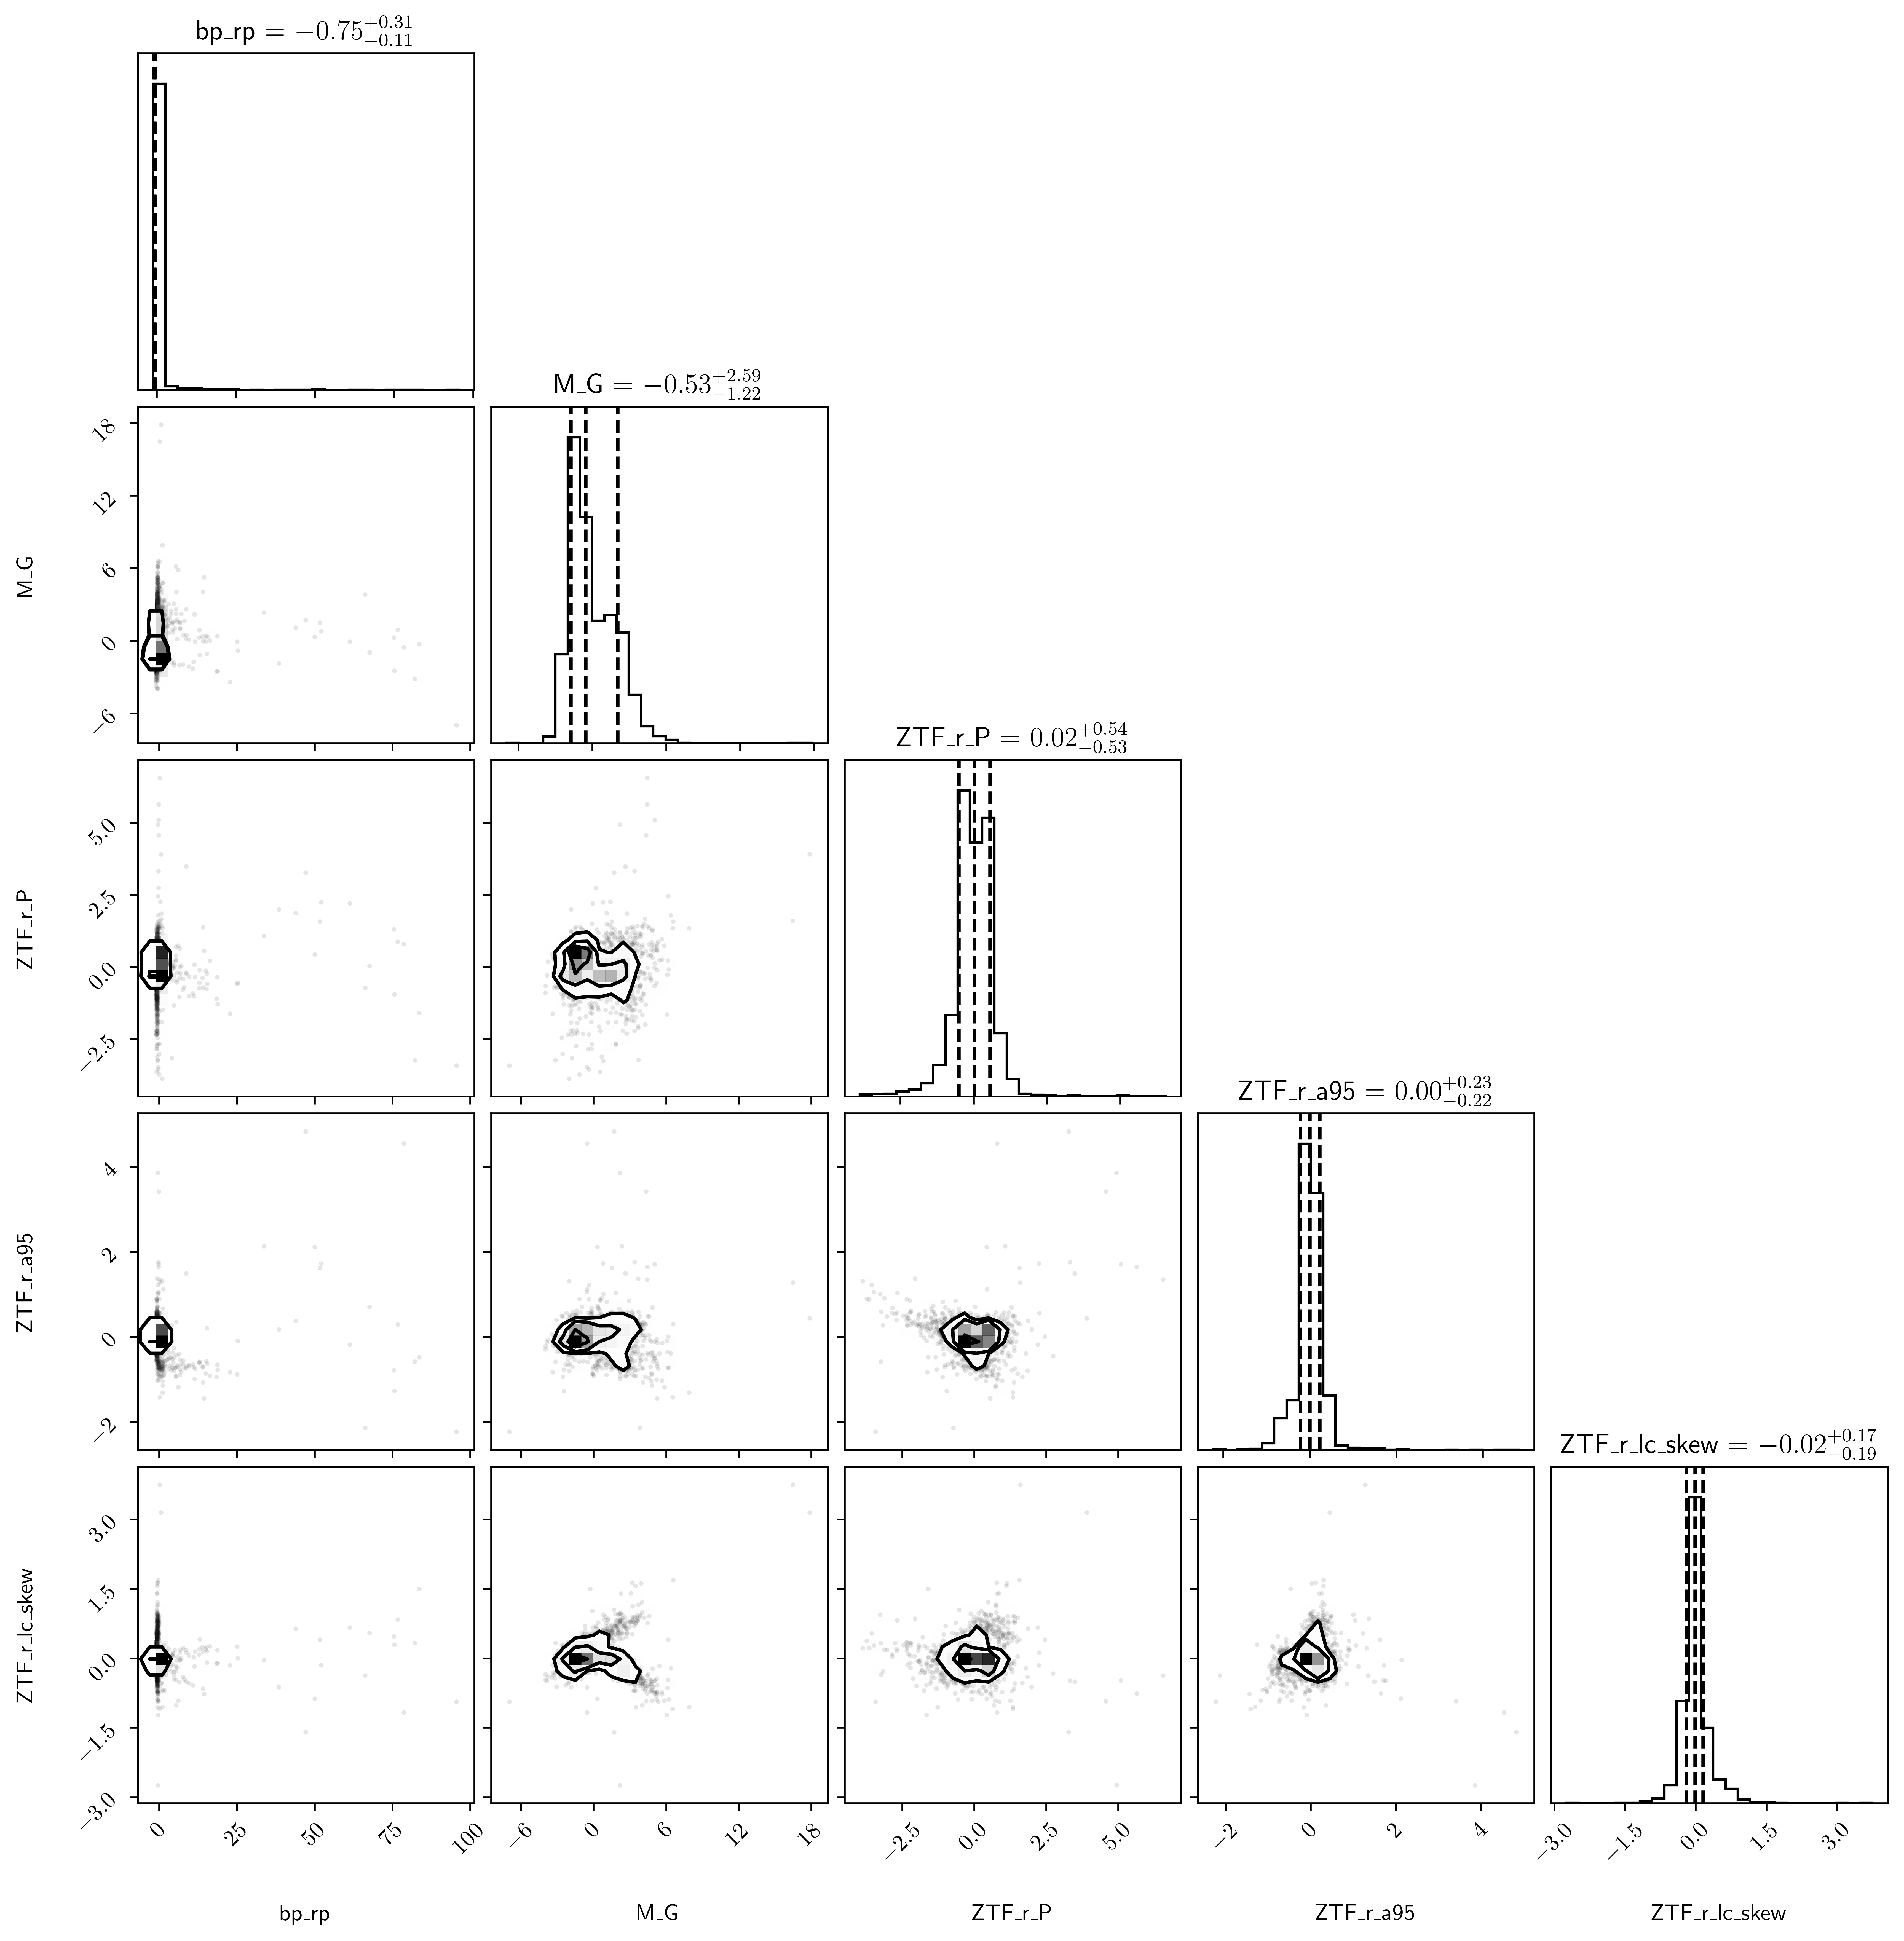

In [27]:
# <function corner.corner.corner(data, bins=20, *, range=None,
# weights=None, color='k', hist_bin_factor=1, smooth=None, smooth1d=None,
# labels=None, label_kwargs=None, titles=None, show_titles=False, title_fmt='.2f',
# title_kwargs=None, truths=None, truth_color='#4682b4', scale_hist=False, quantiles=None,
# verbose=False, fig=None, max_n_ticks=5, top_ticks=False, use_math_text=False,
# reverse=False, labelpad=0.0, hist_kwargs=None, group='posterior', var_names=None, 
# filter_vars=None, coords=None, divergences=False, divergences_kwargs=None, labeller=None,
# **hist2d_kwargs)>
K = pca_X.shape[1]
fig, axes = plt.subplots(K, K, figsize=(12, 12), dpi=600)

corner_plot = corner.corner(pca_X, bins=25, range=None, fig=fig,
                    labels=selected_data.colnames,
                    quantiles=[0.16, 0.5, 0.84],
                    show_titles=True, title_kwargs={"fontsize": 12})


# corner_range = [(-0.1, 4.5), (0, 18), (0, 25), (0, 2), (-4, 4), (0, 1), (0, 3), (1, 10), (1, 10)]
# # corner_range = [(-0.1,4.5), (0,18), (0,10), (0,10), (0,10), (0,10), (0,10), (0,10), (0,10)]


# corner_plot = corner.corner(X, bins=25, range=None, fig=fig,
#                     labels=selected_data.colnames,
#                     quantiles=[0.16, 0.5, 0.84],
#                     show_titles=True, title_kwargs={"fontsize": 12})

# plt.savefig("test2.pdf", dpi=600)

# for ii in np.arange(0, 81, 9):
#     corner_plot.get_axes()[ii].set_xlim(-0.1, 4.5)
    
# for ii in np.arange(19, 81, 9):
#     corner_plot.get_axes()[ii].set_xlim(0, 18)
    
# for ii in np.arange(19, 81, 9):
#     corner_plot.get_axes()[ii].set_xlim(0, 25)
    
# for ii in np.arange(19, 81, 9):
#     corner_plot.get_axes()[ii].set_xlim(0, 2)
    
# for ii in np.arange(19, 81, 9):
#     corner_plot.get_axes()[ii].set_xlim(-4, 4)
    
# for ii in np.arange(19, 81, 9):
#     corner_plot.get_axes()[ii].set_xlim(0, 1)
    
# for ii in np.arange(19, 81, 9):
#     corner_plot.get_axes()[ii].set_xlim(0, 3)
    
# for ii in np.arange(19, 81, 9):
#     corner_plot.get_axes()[ii].set_xlim(0, 10)
    
# for ii in np.arange(19, 81, 9):
#     corner_plot.get_axes()[ii].set_xlim(0, 10)

    
# corner_plot.get_axes()[5].tick_params(axis='y', which='major', labelsize=15, width=2.0, length=10)

# corner_plot.get_axes()[10].tick_params(axis='y', which='major', labelsize=15, width=2.0, length=10)


# corner_plot.get_axes()[15].tick_params(axis='y', which='major', labelsize=15, width=2.0, length=10)


# corner_plot.get_axes()[20].tick_params(axis='x', which='major', labelsize=15, width=2.0, length=10)
# corner_plot.get_axes()[21].tick_params(axis='x', which='major', labelsize=15, width=2.0, length=10)
# corner_plot.get_axes()[22].tick_params(axis='x', which='major', labelsize=15, width=2.0, length=10)
# corner_plot.get_axes()[23].tick_params(axis='x', which='major', labelsize=15, width=2.0, length=10)
# corner_plot.get_axes()[24].tick_params(axis='x', which='major', labelsize=15, width=2.0, length=10)


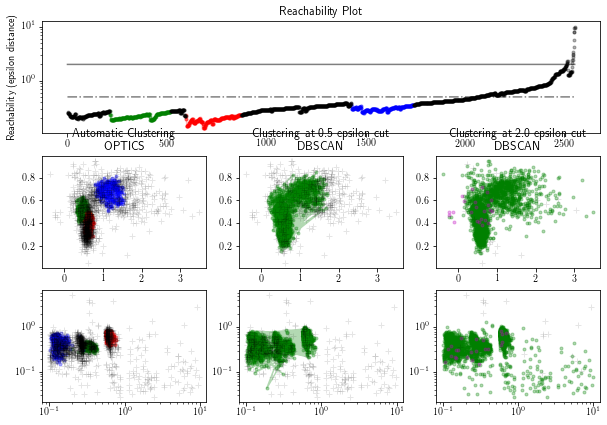

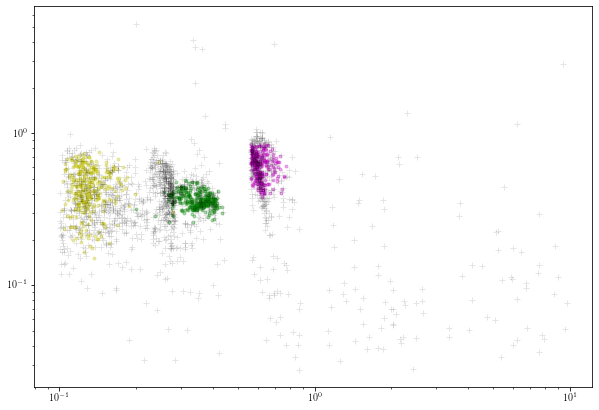

In [34]:
from sklearn.cluster import OPTICS, cluster_optics_dbscan

# clust = OPTICS(min_samples=10, xi=0.0, min_cluster_size=100)

clust = OPTICS(
    min_samples=10,
    max_eps=np.inf,
    metric='minkowski',
    p=2,
    metric_params=None,
    cluster_method='xi',
    eps=None,
    xi=0.0,
    predecessor_correction=True,
    min_cluster_size=250,
    algorithm='auto',
    leaf_size=30,
    memory=None,
    n_jobs=None,
)

x_index1 = 0
y_index1 = 3

x_index2 = 1
y_index2 = 4

# Run the fit
# clust.fit(X)
clust.fit(X_scaled)

labels_050 = cluster_optics_dbscan(
    reachability=clust.reachability_,
    core_distances=clust.core_distances_,
    ordering=clust.ordering_,
    eps=0.5,
)
labels_200 = cluster_optics_dbscan(
    reachability=clust.reachability_,
    core_distances=clust.core_distances_,
    ordering=clust.ordering_,
    eps=2,
)

space = np.arange(len(X_scaled))
reachability = clust.reachability_[clust.ordering_]
labels = clust.labels_[clust.ordering_]

plt.figure(figsize=(10, 7))
G = gridspec.GridSpec(3, 3)
ax1 = plt.subplot(G[0, :])
ax2 = plt.subplot(G[1, 0])
ax3 = plt.subplot(G[1, 1])
ax4 = plt.subplot(G[1, 2])

ax5 = plt.subplot(G[2, 0])
ax6 = plt.subplot(G[2, 1])
ax7 = plt.subplot(G[2, 2])

# Reachability plot
colors = ["g", "r", "b", "y", "c", "orange"]
for klass, color in zip(range(0, 5), colors):
    Xk = space[labels == klass]
    Rk = reachability[labels == klass]
    ax1.plot(Xk, Rk, color=color, marker=".", alpha=0.3)
ax1.plot(space[labels == -1], reachability[labels == -1], "k.", alpha=0.3)
ax1.plot(space, np.full_like(space, 2.0, dtype=float), "k-", alpha=0.5)
ax1.plot(space, np.full_like(space, 0.5, dtype=float), "k-.", alpha=0.5)
ax1.set_ylabel("Reachability (epsilon distance)")
ax1.set_title("Reachability Plot")

ax1.set_yscale('log')

# OPTICS
for klass, color in zip(range(0, 5), colors):
    Xk = X[clust.labels_ == klass]
    ax2.plot(Xk[:, x_index1], Xk[:, y_index1], color=color, marker=".", alpha=0.3)
ax2.plot(X[clust.labels_ == -1, x_index1], X[clust.labels_ == -1, y_index1], "k+", alpha=0.1)
ax2.set_title("Automatic Clustering\nOPTICS")

# DBSCAN at 0.5
colors = ["g", "greenyellow", "olive", "r", "b", "c"]
for klass, color in zip(range(0, 6), colors):
    Xk = X[labels_050 == klass]
    ax3.plot(Xk[:, x_index1], Xk[:, y_index1], color, alpha=0.3, marker=".")
ax3.plot(X[labels_050 == -1, x_index1], X[labels_050 == -1, y_index1], "k+", alpha=0.1)
ax3.set_title("Clustering at 0.5 epsilon cut\nDBSCAN")

# DBSCAN at 2.
colors = ["g.", "m.", "y.", "c."]
for klass, color in zip(range(0, 4), colors):
    Xk = X[labels_200 == klass]
    ax4.plot(Xk[:, x_index1], Xk[:, y_index1], color, alpha=0.3)
ax4.plot(X[labels_200 == -1, x_index1], X[labels_200 == -1, y_index1], "k+", alpha=0.1)
ax4.set_title("Clustering at 2.0 epsilon cut\nDBSCAN")





# OPTICS
colors = ["g.", "r.", "b.", "y.", "c."]
for klass, color in zip(range(0, 5), colors):
    Xk = X[clust.labels_ == klass]
    ax5.plot(Xk[:, x_index2], Xk[:, y_index2], color, alpha=0.3)
ax5.plot(X[clust.labels_ == -1, x_index2], X[clust.labels_ == -1, y_index2], "k+", alpha=0.1)
# ax5.set_title("Automatic Clustering\nOPTICS")

# DBSCAN at 0.5
colors = ["g", "greenyellow", "olive", "r", "b", "c"]
for klass, color in zip(range(0, 6), colors):
    Xk = X[labels_050 == klass]
    ax6.plot(Xk[:, x_index2], Xk[:, y_index2], color, alpha=0.3, marker=".")
ax6.plot(X[labels_050 == -1, x_index2], X[labels_050 == -1, y_index2], "k+", alpha=0.1)
# ax6.set_title("Clustering at 0.5 epsilon cut\nDBSCAN")

# DBSCAN at 2.
colors = ["g.", "m.", "y.", "c."]
for klass, color in zip(range(0, 4), colors):
    Xk = X[labels_200 == klass]
    ax7.plot(Xk[:, x_index2], Xk[:, y_index2], color, alpha=0.3)
ax7.plot(X[labels_200 == -1, x_index2], X[labels_200 == -1, y_index2], "k+", alpha=0.1)
# ax7.set_title("Clustering at 2.0 epsilon cut\nDBSCAN")

ax5.set_xscale('log')
ax6.set_xscale('log')
ax7.set_xscale('log')

ax5.set_yscale('log')
ax6.set_yscale('log')
ax7.set_yscale('log')





plt.figure(figsize=(10, 7))
ax = plt.gca()

# colors = ["g.", "r.", "b.", "y.", "c."]
for klass, color in zip(range(0, 6), colors):
    Xk = X[clust.labels_ == klass]
    ax.plot(Xk[:, x_index2], Xk[:, y_index2], color, alpha=0.3)
ax.plot(X[clust.labels_ == -1, x_index2], X[clust.labels_ == -1, y_index2], "k+", alpha=0.1)

ax.set_xscale('log')
ax.set_yscale('log')